In [1]:
import pandas as pd
df = pd.read_csv('data/insurance_data.csv', index_col=0)

In [2]:
df.head()

,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
index,,,,,,,,,,
0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [3]:
df.columns

Index(['PatientID', 'age', 'gender', 'bmi', 'bloodpressure', 'diabetic',
       'children', 'smoker', 'region', 'claim'],
      dtype='object')

In [4]:
len(df)

1340

In [5]:
df.isnull().sum()

PatientID        0
age              5
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           3
claim            0
dtype: int64

## Quantidade insignificante de NAN values então irei removélos do dataset.

In [6]:
df = df.dropna()

In [7]:
df_numerico = df.iloc[:, 1:]

In [8]:
df_numerico.describe()

,age,bmi,bloodpressure,children,claim
count,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000
mean,38.086336,30.658333,94.189189,1.099850,13325.246426
std,11.112804,6.118967,11.445173,1.205958,12109.620712
min,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,29.000000,26.200000,86.000000,0.000000,4760.157500
50%,38.000000,30.350000,92.000000,1.000000,9412.965000
75%,47.000000,34.725000,99.000000,2.000000,16781.327500
max,60.000000,53.100000,140.000000,5.000000,63770.430000


## Não parece ter nenhum dado que chame muita atenção principalmente nas colunas inteiras, vamos calcular o IQR das colunas numéricas para observarmos se realmente os dados estão seguindo uma distribuição normal ou não.

In [ ]:
def remover_outliers_iqr(df_numerico):
    """
    Remove outliers de um DataFrame numérico usando o método IQR.

    Para cada coluna numérica, identifica outliers usando o intervalo interquartil (IQR)
    e remove as linhas que contêm outliers em qualquer coluna.

    Args:
        df_numerico: DataFrame pandas contendo apenas colunas numéricas.

    Returns:
        DataFrame pandas com os outliers removidos.
    """
    df_sem_outliers = df_numerico.copy() # Cria uma cópia para não modificar o DataFrame original diretamente

    for column in df_sem_outliers.columns:
        if pd.api.types.is_numeric_dtype(df_sem_outliers[column]): # Para pegar apenas as colunas númericas e ignorar boolean
            Q1 = df_sem_outliers[column].quantile(0.25)
            Q3 = df_sem_outliers[column].quantile(0.75)
            IQR = Q3 - Q1

            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            outliers = df_sem_outliers[(df_sem_outliers[column] < limite_inferior) | (df_sem_outliers[column] > limite_superior)]

            if not outliers.empty:
                print(f"Outliers removidos da coluna '{column}':")
                print(outliers[column])
                print(f"Quantidade de outliers removidos: {len(outliers)}")

                # Remove as linhas que contêm outliers da coluna atual
                df_sem_outliers = df_sem_outliers.drop(outliers.index) # Remove as linhas com os índices dos outliers
                df_sem_outliers = df_sem_outliers.reset_index(drop=True) # Reseta o índice após a remoção

                print("-" * 50)
            else:
                print(f"Não foram encontrados outliers significativos na coluna '{column}'.")
                print("-" * 50)

    print("DataFrame após remoção de outliers:")
    print(df_sem_outliers.head()) # Mostra as primeiras linhas do DataFrame resultante
    return df_sem_outliers

df_sem_outliers = remover_outliers_iqr(df_numerico)

Não foram encontrados outliers significativos na coluna 'age'.
--------------------------------------------------
Outliers removidos da coluna 'bmi':
index
9       53.1
141     50.4
675     48.1
696     47.7
802     49.1
1299    52.6
1306    47.6
Name: bmi, dtype: float64
Quantidade de outliers removidos: 7
--------------------------------------------------
Outliers removidos da coluna 'bloodpressure':
1134    128
1137    135
1139    128
1140    126
1141    126
       ... 
1310    133
1317    120
1318    127
1319    125
1321    120
Name: bloodpressure, Length: 62, dtype: int64
Quantidade de outliers removidos: 62
--------------------------------------------------
Não foram encontrados outliers significativos na coluna 'children'.
--------------------------------------------------
Outliers removidos da coluna 'claim':
1148    28868.66
1149    28923.14
1150    28950.47
1151    29186.48
1152    29330.98
          ...   
1258    48970.25
1259    55135.40
1260    60021.40
1261    62592.87
1

## A intuição inicial estava errada e existem uma grande quantidade de outliers, principalmente na coluna de claim, coluna essa que será o nosso rótulo

## Vamos utilizar a coluna de Claim como nosso target para o classificador, assim vamos fazer uma análise da distriuição desses dados.

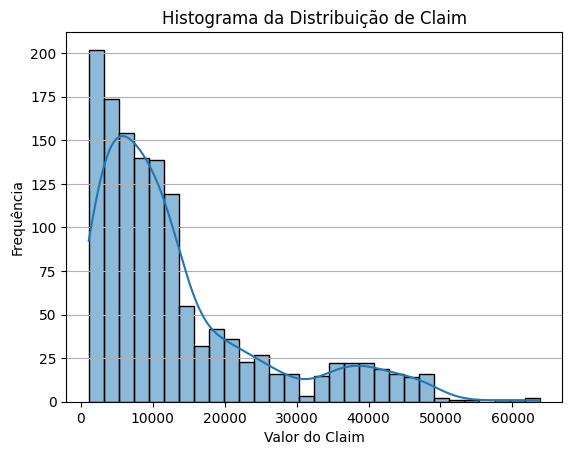

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df['claim'], kde=True, bins=30)
plt.title('Histograma da Distribuição de Claim')
plt.xlabel('Valor do Claim')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

## Vamos extrair o nosso dataframe com o pré processamento

In [23]:
df_sem_outliers.to_csv('artefatos/insurance_data_sem_outliers.csv', index=False)